In [2]:
import os
from pathlib import Path

#auto load the eemeter module
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import time
import pickle

from hourly_test_utils import *
from applied_data_science.bigquery.data import Meter_Data
from eemeter import eemeter as em
from eemeter.common.metrics import BaselineTestingMetrics as Metrics

import multiprocessing as mp


In [3]:
separate_folder = "/app/.recurve_cache/mce_3_yr_precovid/Hyperparameter_opt/separateV1"
subsamples = [1, 2, 3, 4, 5, 6]
has_solars = [True, False]
results = {}
for sub in subsamples:
    for has_solar in has_solars:
        path = os.path.join(separate_folder, f"subsample_{sub}_solar_meter_{has_solar}.pkl")
        with open(path, "rb") as f:
            data = pickle.load(f)
            loss = data["loss"]
            x_opt = data["x_opt"]
            results[(sub, has_solar)] = (loss, x_opt)

print(results)

#load the whole populaiton best
best_res = {}
alltogether_file = "/app/.recurve_cache/mce_3_yr_precovid/Hyperparameter_opt/alltogetherV1/subsample_all_solar_meter_all.pkl"
with open(alltogether_file, "rb") as f:
    data = pickle.load(f)
    loss = data[0]
    x_opt = data[1]
    best_res["all"] = (loss, x_opt)

{(1, True): (0.9142851506113835, array([0.12944037, 0.03186457])), (1, False): (1.4646280046723923, array([0.13393872, 0.08933357])), (2, True): (0.9909293343211804, array([0.15010975, 0.02613309])), (2, False): (1.654009717620133, array([0.11941291, 0.11903004])), (3, True): (1.0361939067038552, array([0.13199963, 0.0340425 ])), (3, False): (8.976657752777479, array([0.5660451 , 0.07299967])), (4, True): (0.9782937455628165, array([0.16729772, 0.01996999])), (4, False): (1.3821802665728755, array([0.1265366 , 0.10533426])), (5, True): (0.9807574602081821, array([0.12335513, 0.03429297])), (5, False): (1.5446389769455073, array([0.17330459, 0.10303819])), (6, True): (0.9027653530666153, array([0.12701622, 0.0349357 ])), (6, False): (1.4674593609684015, array([0.12165886, 0.14034092]))}


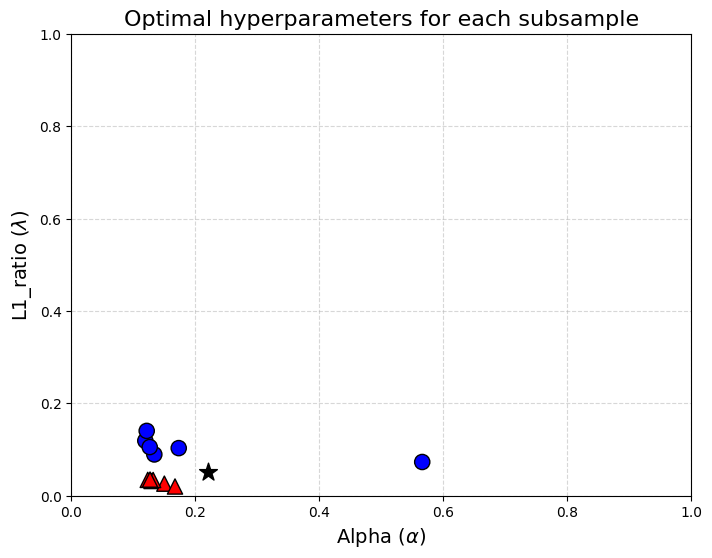

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Get all of the x opts for true and false cases
x_opts_true = [results[key][1] for key in results if key[1]==True]
x_opts_false = [results[key][1] for key in results if key[1]==False]

# Assign colors for true and false cases
colors_true = ['red' for x in x_opts_true]
colors_false = ['blue' for x in x_opts_false]

# Set the figure size
plt.figure(figsize=(8, 6))
plt.rcParams['figure.dpi'] = 500


# Plot the scatter points
plt.scatter([x[0] for x in x_opts_true], [x[1] for x in x_opts_true], c=colors_true, marker='^' , s=120, label='Solar Meters', edgecolors='black', linewidths=1)
plt.scatter([x[0] for x in x_opts_false], [x[1] for x in x_opts_false], c=colors_false, s=120, label='Non-Solar Meters', edgecolors='black', linewidths=1)

# Plot the best result with a black star
plt.scatter(best_res['all'][1][0], best_res['all'][1][1], c='black', marker='*', label='Best Total Population Result', s=180)

# Set the x and y limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Set the x and y labels with larger fonts
plt.xlabel(r"Alpha ($\alpha$)", fontsize=14)
plt.ylabel(r"L1_ratio ($\lambda$)", fontsize=14)

# Set the title with larger font
plt.title("Optimal hyperparameters for each subsample", fontsize=16)

# Add a legend with larger font
# plt.legend(fontsize=12)

# Show the grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

In [67]:
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    ALPHA=0.1,
    L1_RATIO=0.1,
    # ALPHA=0.214495100289607,
    # L1_RATIO=0.05470843655047026,
    SEED=42
)
optimal_errors = {
    'train': [],
    'test': []
}
initial_errors = {
    'train': [],
    'test': []
}
subsamples = [1, 2, 3, 4, 5, 6]
has_solars = [True, False]
all_results = {}
modes = ['initial', 'optimal']
for sub in subsamples:
    for has_solar in has_solars:
        for mode in modes:
            if mode == 'initial':
                settings = em.HourlySettings(
                    TRAIN_FEATURES=['ghi'],
                    ALPHA=0.1,
                    L1_RATIO=0.1,
                    SEED=42
                )
            else:
                settings = em.HourlySettings(
                    TRAIN_FEATURES=['ghi'],
                    ALPHA=results[(sub, has_solar)][1][0],
                    L1_RATIO=results[(sub, has_solar)][1][1],
                    SEED=42
                )
            solar_meters = [has_solar]
            subsamples = [sub]
            kwargs = {
                'settings': settings,
                'subsamples': subsamples,
                'solar_meters': solar_meters,
                'mp' : True,
                'max_id': -1
            }
            prf = Population_Run_Features(**kwargs)
            prf._load_data()
            prf.run()
            calc_id_kf_num = 0
            train_errors = []
            test_errors = []
            for res in prf.results:
                _, _, errors = res
                if (errors!=None) and (errors['train'][0]!= np.inf) and (errors['test'][0]!= np.inf):

                    calc_id_kf_num += 1
                    train_errors.append(errors['train'])
                    test_errors.append(errors['test'])
            print(sub, has_solar, mode)
            print(len(prf.results))
            print(f"Calculated {calc_id_kf_num} id/kfold pairs")
            print('avg. train pnrmse:', np.mean(train_errors))
            print('avg. test pnrmse:', np.mean(test_errors))
            if mode == 'initial':
                initial_errors['train'].append(np.mean(train_errors))
                initial_errors['test'].append(np.mean(test_errors))
            else:
                optimal_errors['train'].append(np.mean(train_errors))
                optimal_errors['test'].append(np.mean(test_errors))
            all_results[(sub, has_solar, mode)] = (train_errors, test_errors)

# # save the results
# new_path = "/app/.recurve_cache/mce_3_yr_precovid/Hyperparameter_opt/all_results.pkl"
# with open(new_path, "wb") as f:
#     pickle.dump(all_results, f)

1 True initial
2992
Calculated 2992 id/kfold pairs
avg. train pnrmse: 0.7384222738289371
avg. test pnrmse: 0.9147681362583479
1 True optimal
2992
Calculated 2992 id/kfold pairs
avg. train pnrmse: 0.7336465136146609
avg. test pnrmse: 0.9142851506113815
1 False initial
2996
Calculated 2996 id/kfold pairs
avg. train pnrmse: 1.2519331680958972
avg. test pnrmse: 1.4650923116237509
1 False optimal
2996
Calculated 2996 id/kfold pairs
avg. train pnrmse: 1.2631884239441213
avg. test pnrmse: 1.46462800467239


In [5]:
all_results_path = "/app/.recurve_cache/mce_3_yr_precovid/Hyperparameter_opt/all_results.pkl"
#read the results
with open(all_results_path, "rb") as f:
    all_results = pickle.load(f)

global_results_path = "/app/.recurve_cache/mce_3_yr_precovid/Hyperparameter_opt/best_global_results.pkl"
#read the results
with open(global_results_path, "rb") as f:
    global_results = pickle.load(f)


In [6]:
import pandas as pd

subsamples = [1, 2, 3, 4, 5, 6]
has_solars = [True, False]
sc_res = pd.DataFrame(columns=['subsample', 'solar_meter', 'mode', 'train_pnrmse', 'test_pnrmse'])
for sc in list(all_results.keys()):
    for sub in subsamples:
        for has_solar in has_solars:
            if (sc[0] == sub) and (sc[1] == has_solar):
                train_pnrmse = np.mean(all_results[sc][0])
                test_pnrmse = np.mean(all_results[sc][1])
                new_row = {'subsample': sub, 'solar_meter': has_solar, 'mode': sc[2], 'train_pnrmse': train_pnrmse, 'test_pnrmse': test_pnrmse}
                sc_res = pd.concat([sc_res, pd.DataFrame([new_row])], ignore_index=True)

sc_res = sc_res.sort_values(by=['subsample', 'solar_meter', 'mode'])
# add global results to the dataframe
global_res = pd.DataFrame(columns=['subsample', 'solar_meter', 'mode', 'train_pnrmse', 'test_pnrmse'])
for sub in subsamples:
    for has_solar in has_solars:
        train_pnrmse = global_results[(sub, has_solar, 'global_optimal')][0]
        test_pnrmse = global_results[(sub, has_solar, 'global_optimal')][1]
        new_row = {'subsample': sub, 'solar_meter': has_solar, 'mode': 'global', 'train_pnrmse': np.mean(train_pnrmse), 'test_pnrmse': np.mean(test_pnrmse)}
        global_res = pd.concat([global_res, pd.DataFrame([new_row])], ignore_index=True)

sc_res = pd.concat([sc_res, global_res], ignore_index=True)
sc_res = sc_res.sort_values(by=['subsample', 'solar_meter', 'mode'])


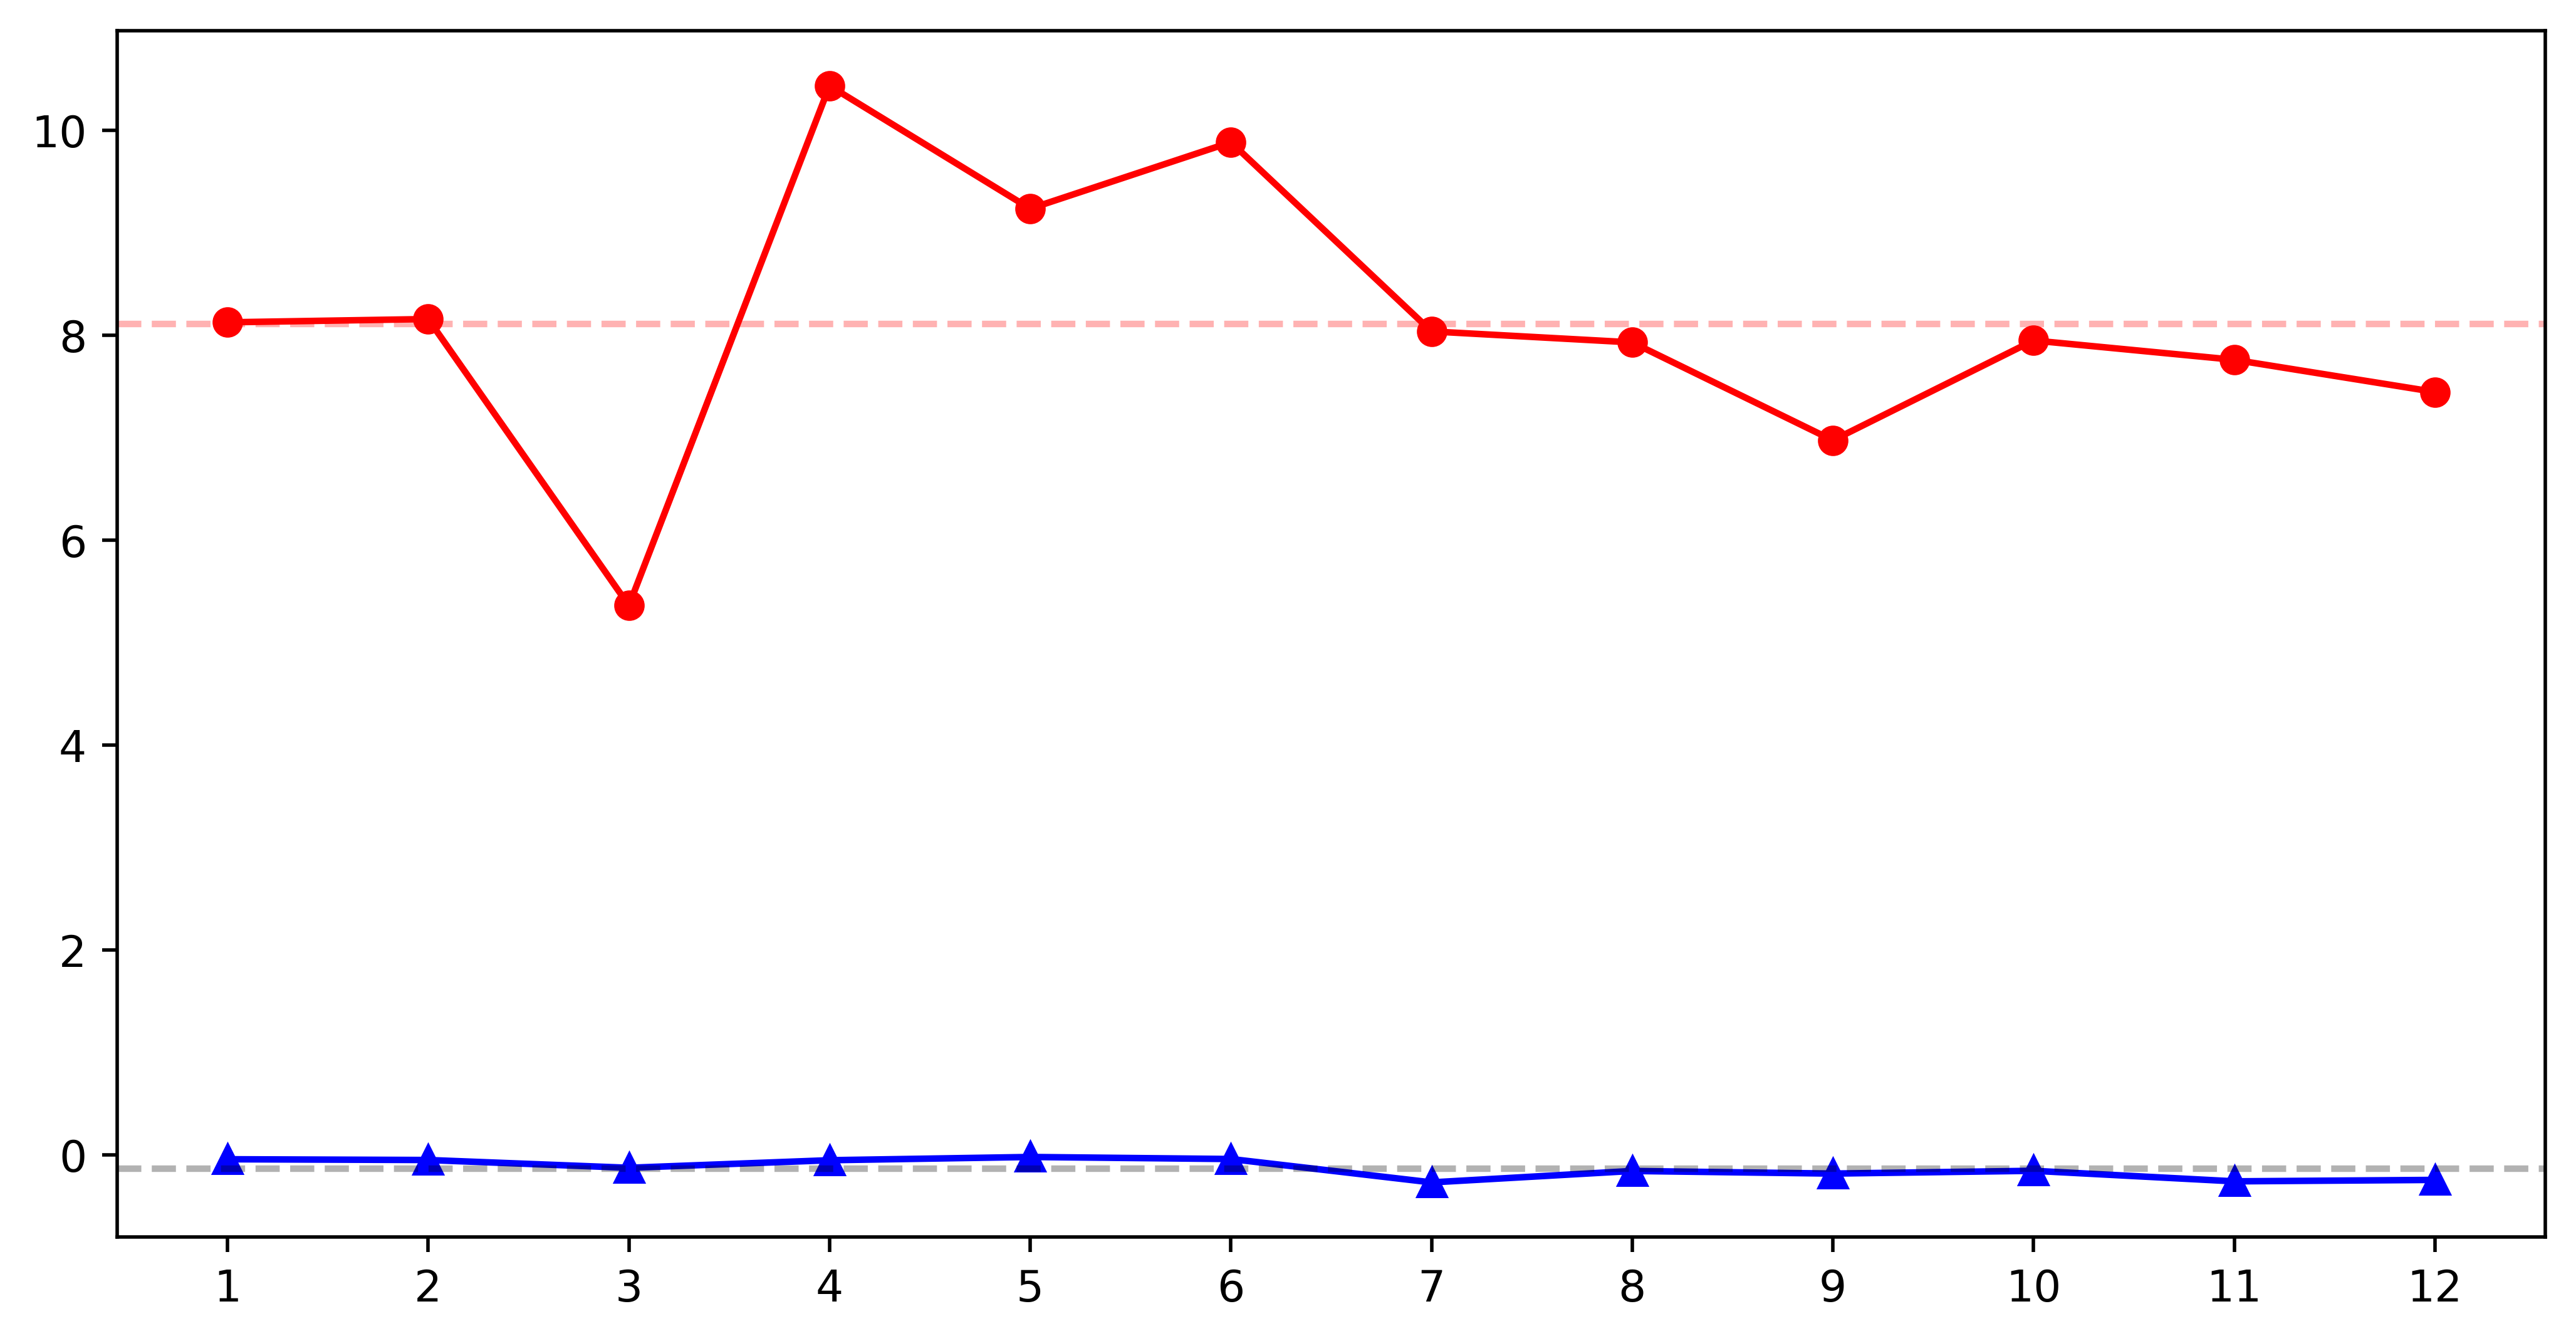

In [7]:
# get global and optimal results for each subsample and solar meter
df_test = sc_res[sc_res['mode'].isin(['global', 'optimal', 'overfit'])]
df_test = df_test.sort_values(by=['solar_meter','subsample'])
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 500
glb = df_test[df_test['mode'] == 'global']['test_pnrmse'].values
opt = df_test[df_test['mode'] == 'optimal']['test_pnrmse'].values
overfit = df_test[df_test['mode'] == 'overfit']['test_pnrmse'].values
percent_diff = -(glb - opt) / glb * 100
percent_diff_overfit = -(glb - overfit) / glb * 100


# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(range(0, len(percent_diff)), percent_diff, marker='^', c='b', label='Optimal')
plt.plot(range(0, len(percent_diff_overfit)), percent_diff_overfit, marker='o', c='r', label='Overfit')
plt.xticks(range(0, len(percent_diff)), range(1, len(percent_diff)+1))
# transparent line at 0
plt.axhline(np.mean(percent_diff), color='black', alpha=0.3, linestyle='--')

# tansparent line at the mean value of the percent difference overfit
plt.axhline(np.mean(percent_diff_overfit), color='red', alpha=0.3, linestyle='--')

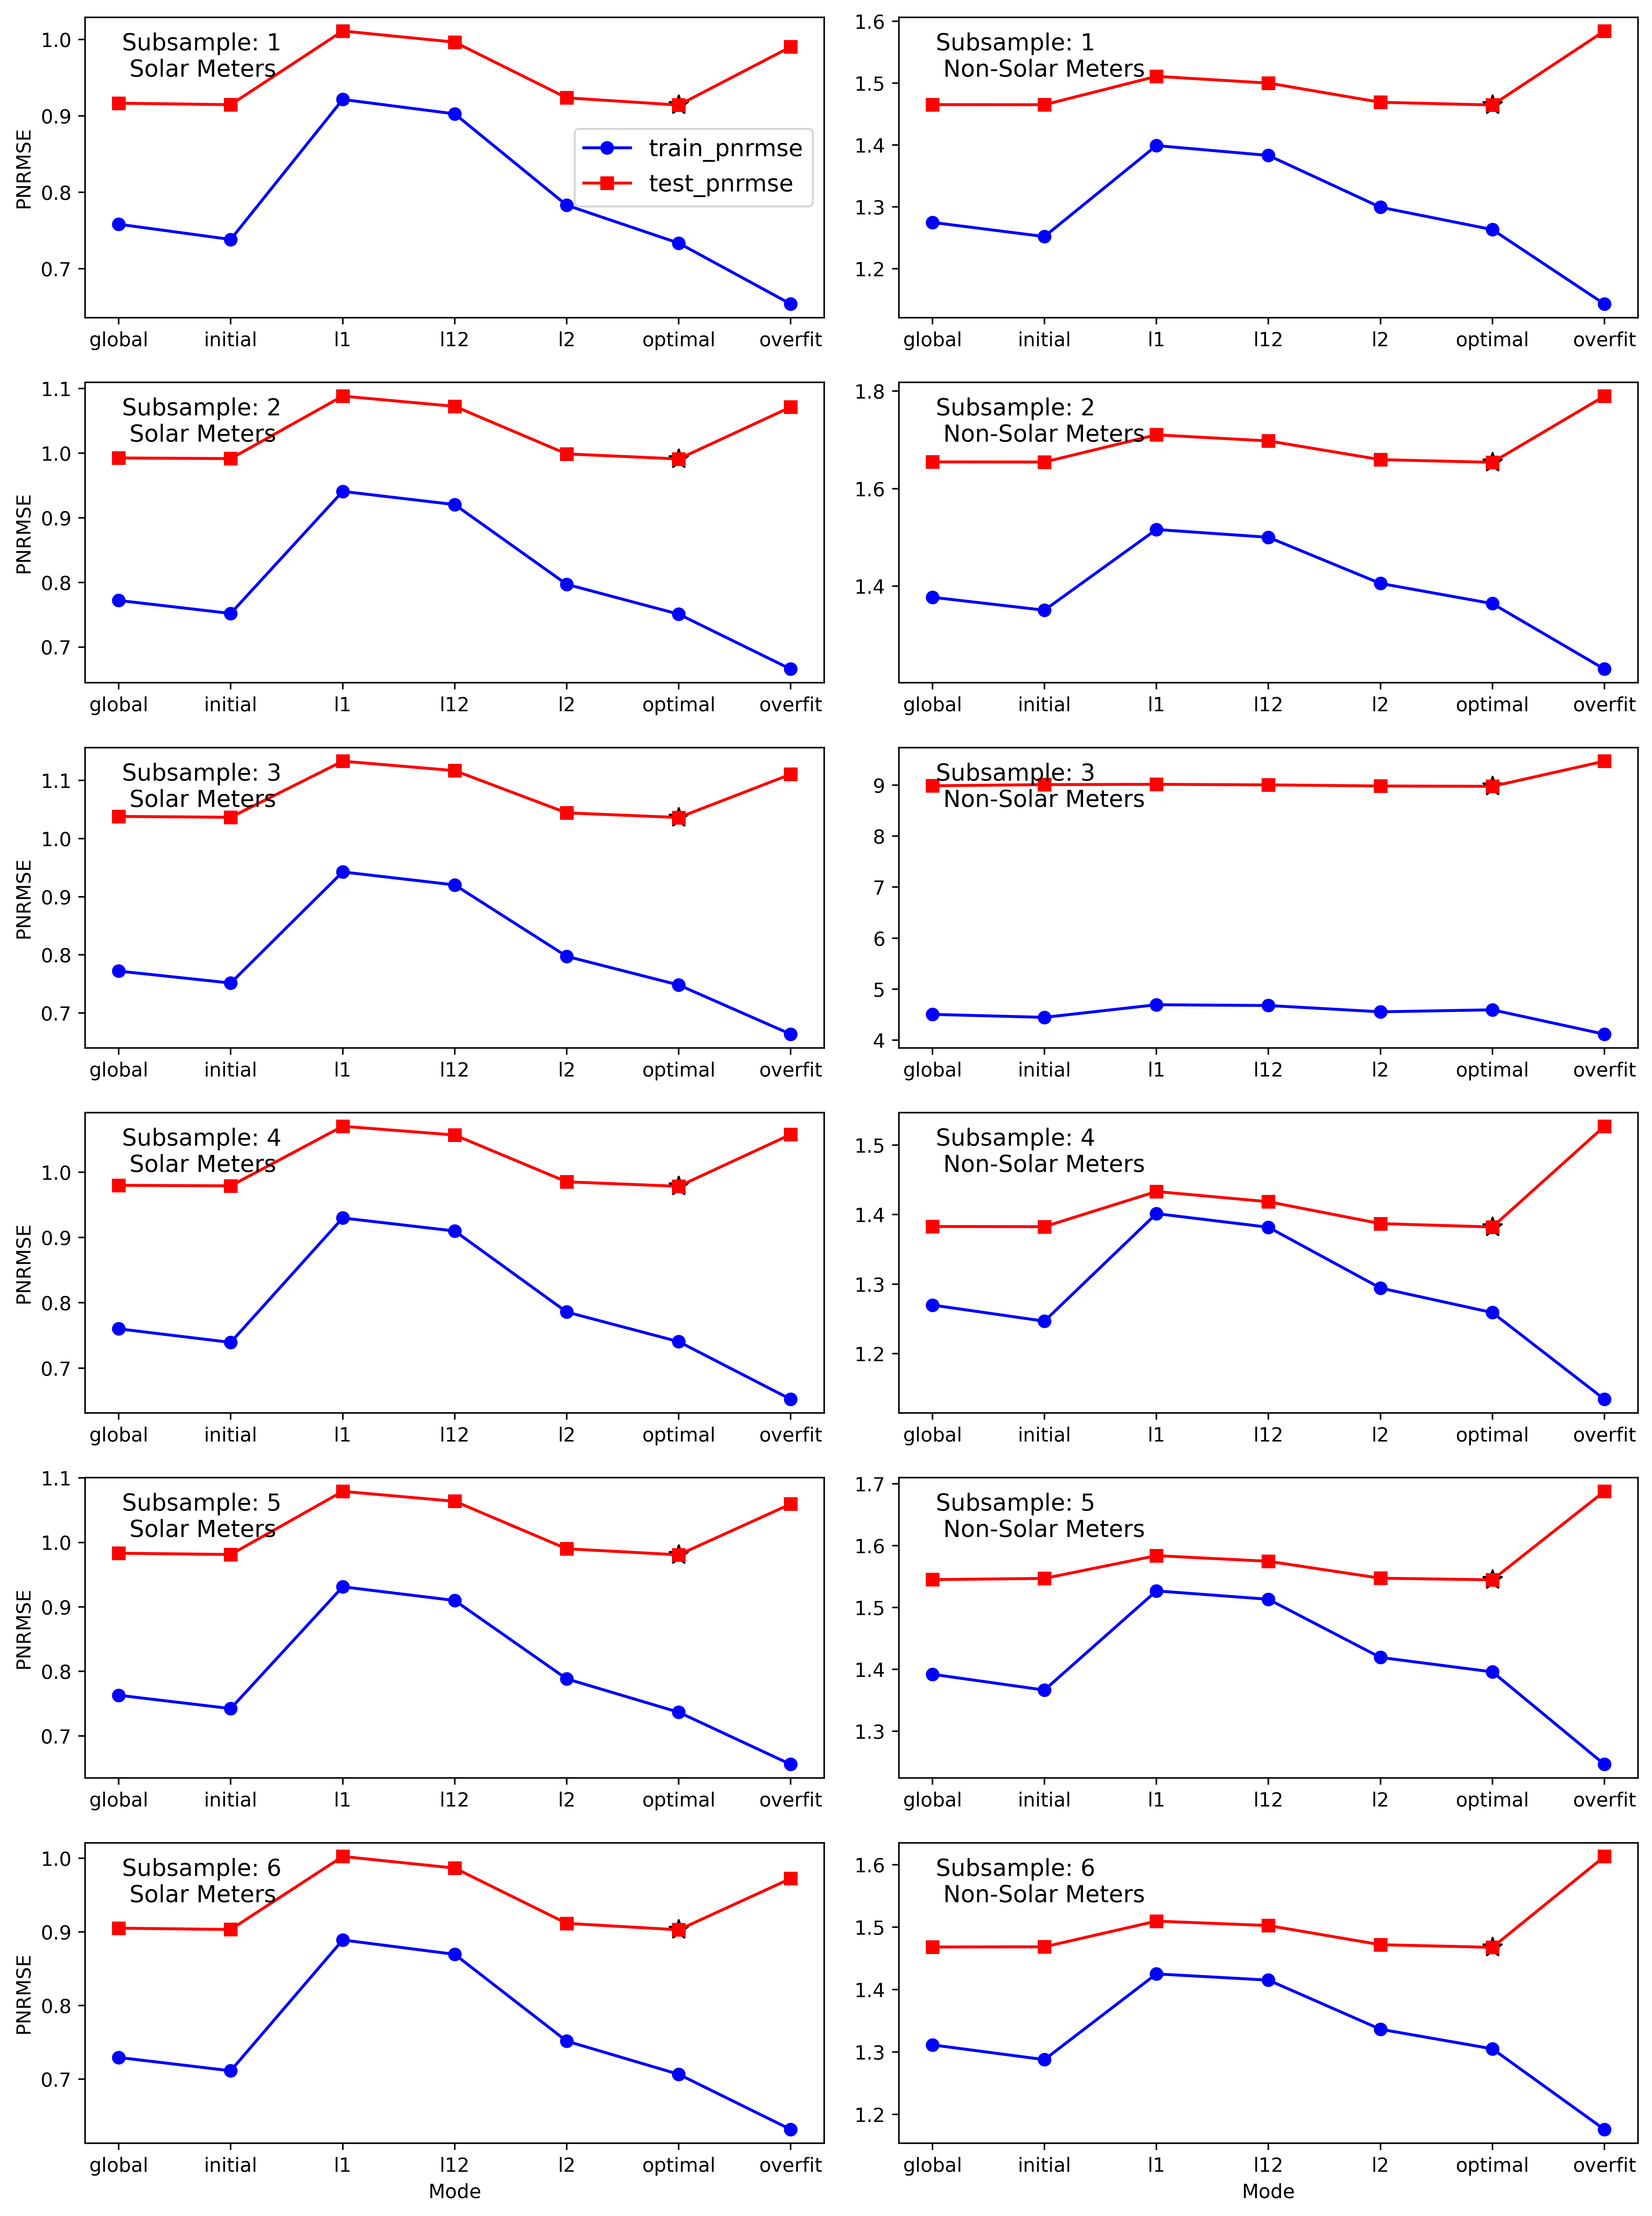

In [8]:
fig, axs = plt.subplots(6, 2, figsize=(12, 16))

import seaborn as sns
import matplotlib.pyplot as plt

# Set the font size for labels and titles
plt.rcParams['font.size'] = 12

# Set the color palette
train_colors = sns.color_palette("viridis", len(sc_res['mode'].unique()))
test_colors = sns.color_palette("deep6", len(sc_res['mode'].unique()))

# define the subplot

# Plot the lines
for i, sub in enumerate(subsamples):
    for j, has_solar in enumerate(has_solars):
        df = sc_res[(sc_res['subsample']==sub) & (sc_res['solar_meter']==has_solar)]
        ax = axs[i, j]
        ax.plot(df['mode'], df['train_pnrmse'], label='train_pnrmse', marker='o', color='b')
        ax.plot(df['mode'], df['test_pnrmse'], label='test_pnrmse', marker='s', color='r')

        # Add small text to show the subsample and solar meter
        if has_solar:
            solat_text = 'Solar Meters'
        else:
            solat_text = 'Non-Solar Meters'
        ax.text(0.05, 0.95, f"Subsample: {sub}\n {solat_text}", horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

        if i == 5:
            ax.set_xlabel('Mode')
        if j == 0:
            ax.set_ylabel('PNRMSE')
        if i == 0 and j == 0:
            ax.legend()

        # Find the minimum test_pnrmse value and its corresponding mode
        min_test_pnrmse = df['test_pnrmse'].min()
        min_mode = df.loc[df['test_pnrmse'].idxmin(), 'mode']
        
        # Plot the minimum test value with a star
        ax.scatter(min_mode, min_test_pnrmse, c='black', marker='*', s=100)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [9]:
# let's load the anomaly subsample
subsample = 3
has_solar = False
settings = em.HourlySettings(
                    TRAIN_FEATURES=['ghi'],
                    ALPHA=best_res["all"][1][0],
                    L1_RATIO=best_res["all"][1][1],
                    SEED=42
                )
dataset = 'mce_3_yr_precovid'
cache_dir = Path("/app/.recurve_cache/data").resolve()

if 'data' in globals():
    del data

data = Meter_Data(dataset, subsample, "hourly", solar=has_solar, cache_dir=cache_dir)
meta = data.df['meta']
subsample_df = data.df['meter']
ids = subsample_df.index.unique()



Loading: /app/.recurve_cache/data/MCE/MCE_3_yr_precovid_non_solar_meta_3.pkl
Done in 0.005 s
Loading: /app/.recurve_cache/data/MCE/MCE_3_yr_precovid_non_solar_hourly_meter_3.pkl
Done in 8.672 s


In [10]:
# see all the errors of subsample 3 False
path3 = "/app/.recurve_cache/mce_3_yr_precovid/Hyperparameter_opt/all_results.pkl"
with open(path3, "rb") as f:
    all_results = pickle.load(f)

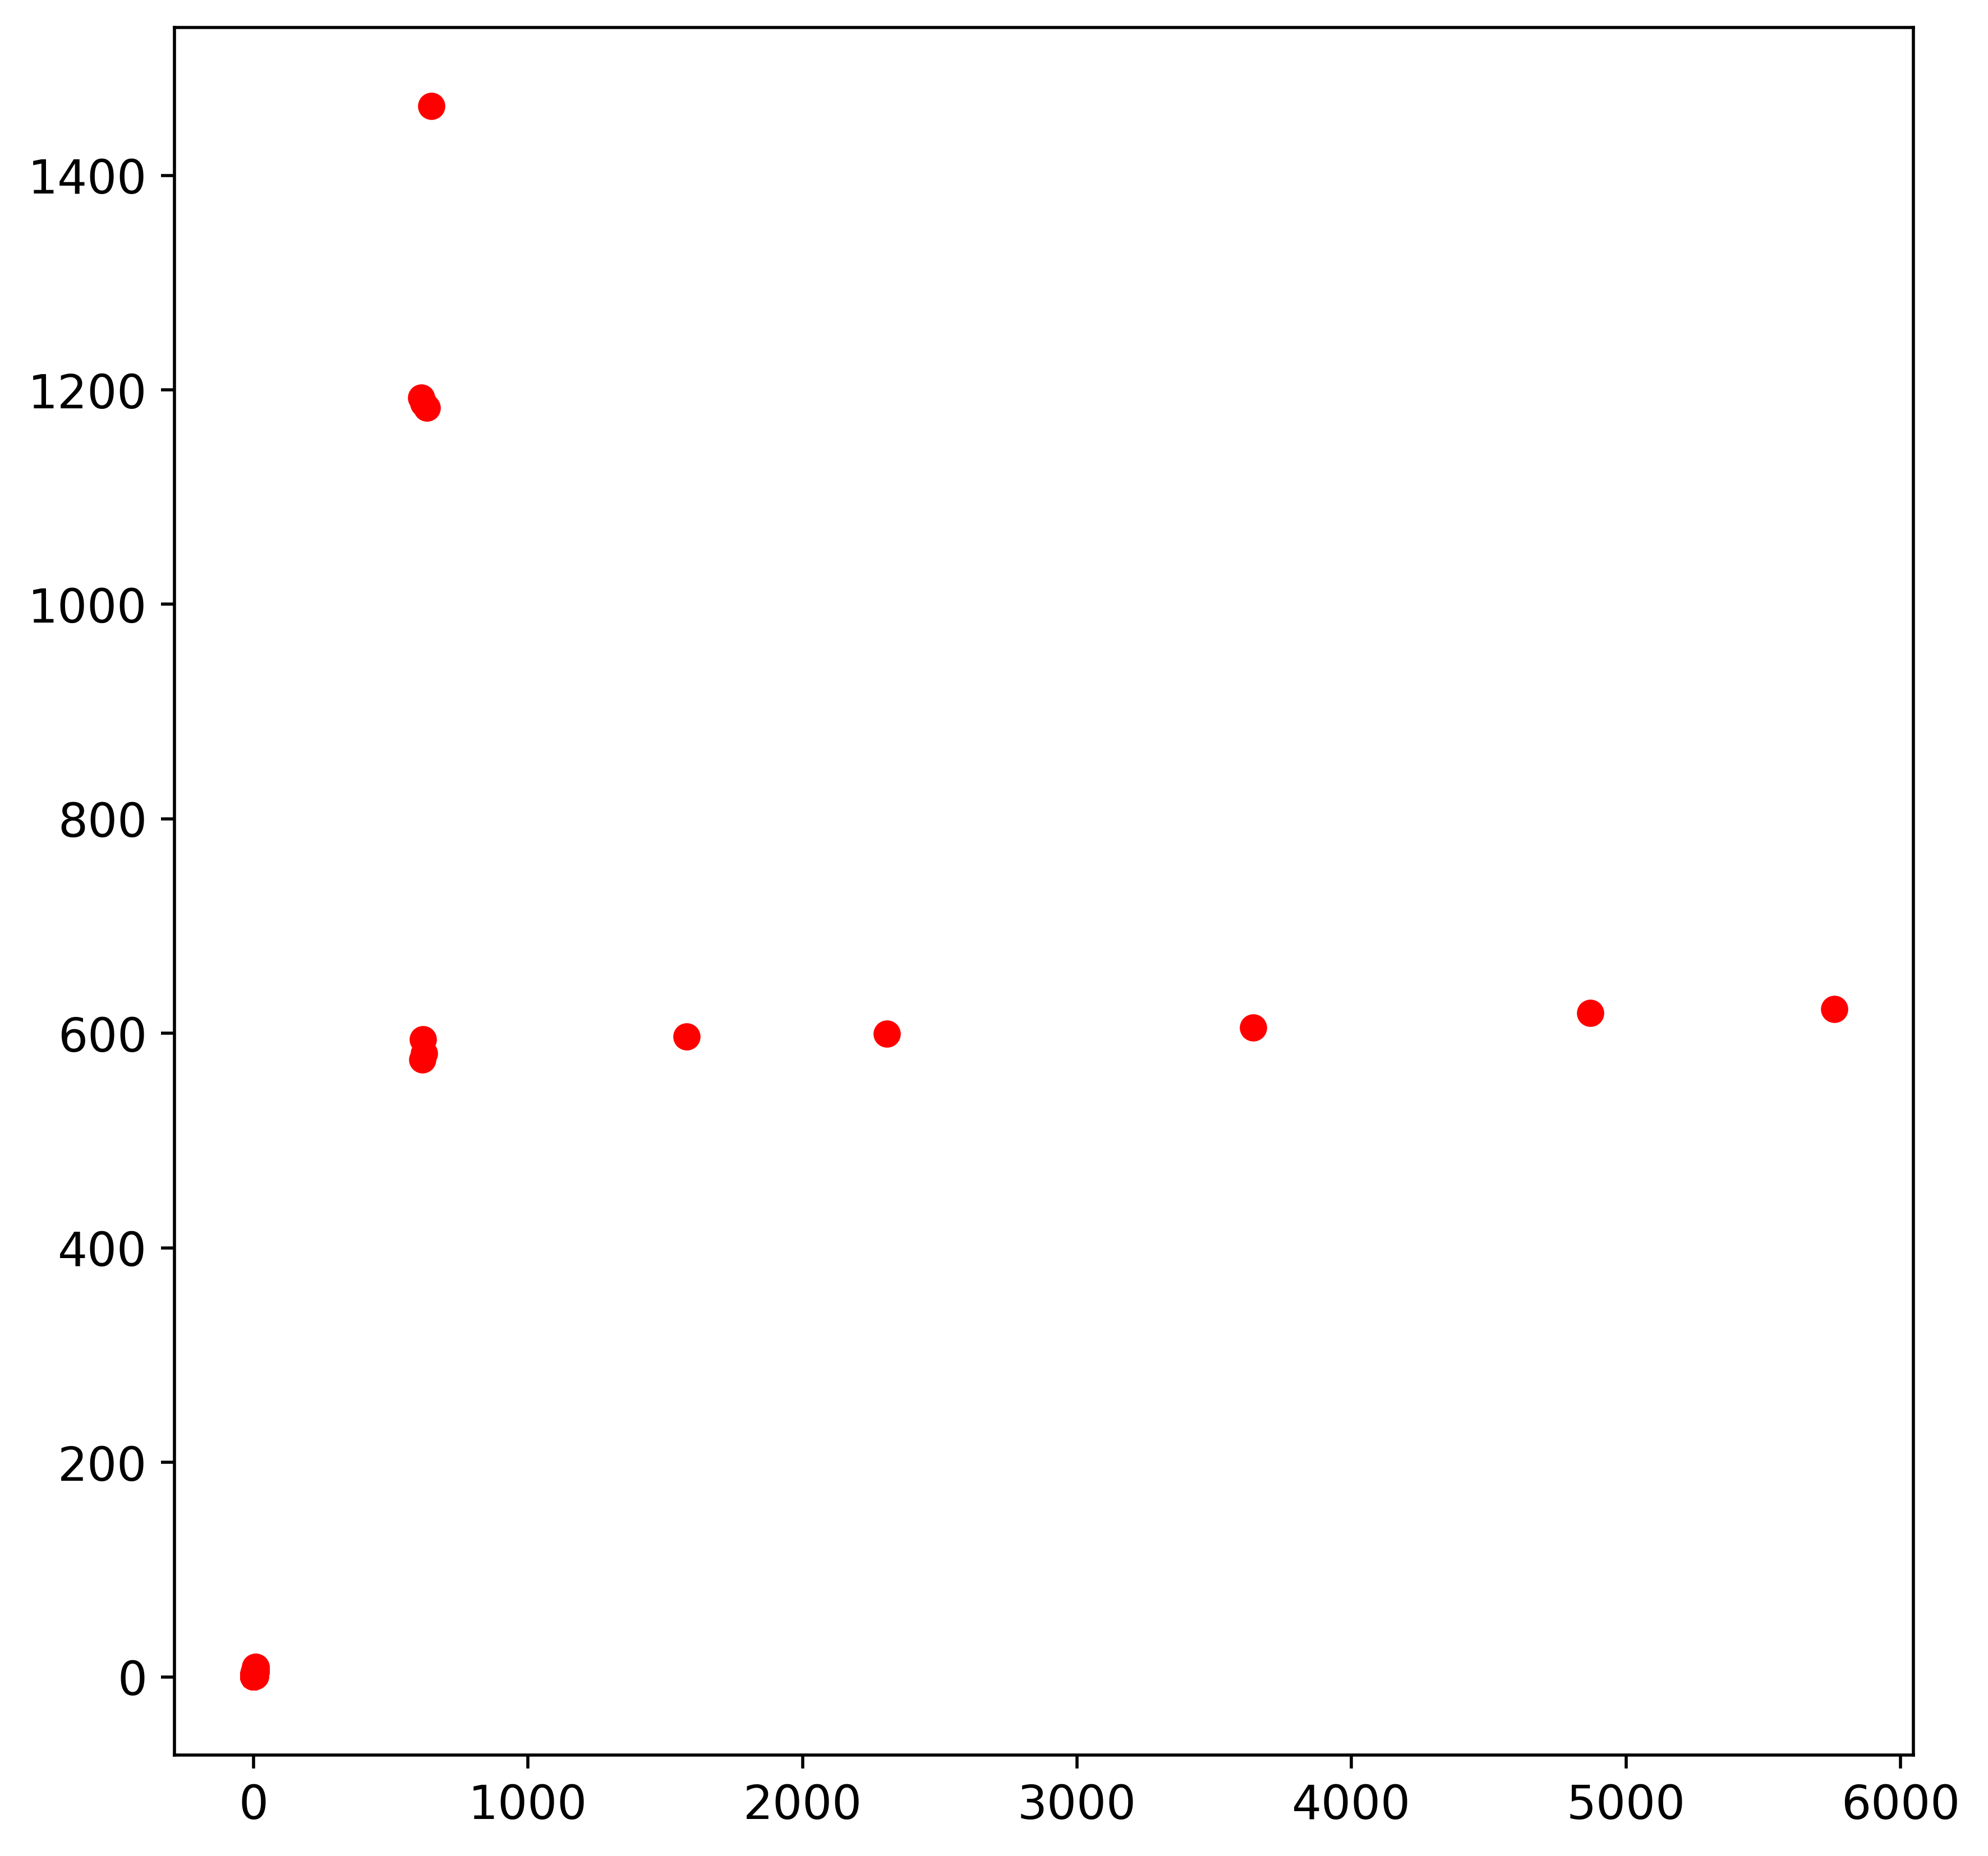

In [14]:
tr_error = all_results[(3, False, 'optimal')][0]
te_error = all_results[(3, False, 'optimal')][1]
anomaly_thr = 1e10
tr_anomalies = [(i, x) for i, x in enumerate(tr_error) if x[0] > anomaly_thr]
te_anomalies = [(i, x) for i, x in enumerate(te_error) if x[0] > anomaly_thr]
#filter out errors larger than 2
tr_error = [x for x in tr_error if x[0] < anomaly_thr]
te_error = [x for x in te_error if x[0] < anomaly_thr]

# show the scatter plot of the train/test average error
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 500
plt.scatter([x[0] for x in te_error], [x[0] for x in tr_error], c='r', label='train')


# plt.plot(tr_error, label='train')
# plt.plot(te_error, label='test')
# plt.legend()
plt.show()

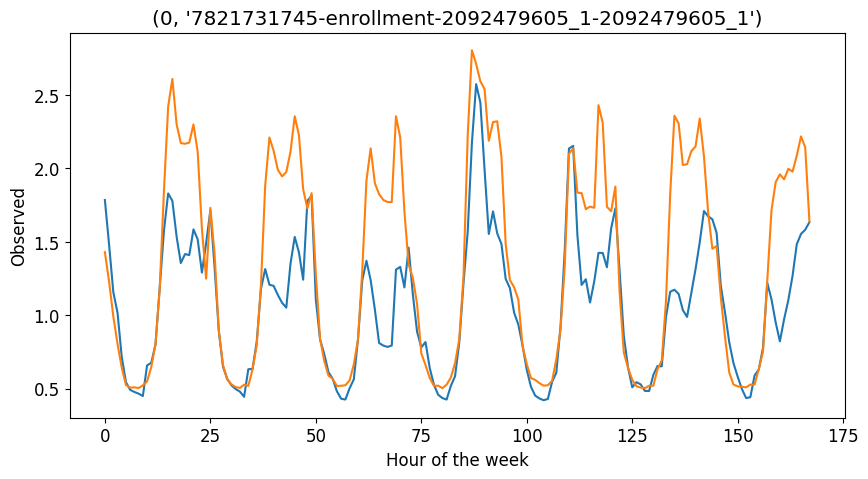

In [196]:
sid = ids[20]
#get hour of the week for the train and test data which is between 0 and 167
def get_hour_of_week(df):
    df['hour'] = df.index.hour
    df['day'] = df.index.dayofweek
    df['hour_of_week'] = df['day']*24 + df['hour']
    # get the average of the observed values for each hour of the week
    df = df.groupby('hour_of_week').agg({'observed': 'mean'}).reset_index()
    return df
# for idx, sid in enumerate(ids):
for idx, sid in enumerate([ids[2633//12]]):

    lat = meta.loc[meta.index == sid].iloc[0]['station_latitude']
    lon = meta.loc[meta.index == sid].iloc[0]['station_longitude']
    sd = subsample_df.loc[sid].copy()
    metadata = {'lat': lat, 'lon': lon, 'sid': sid}

    data_loader = MCE_Data_Loader_Test(settings)
    # sid, df_trains, df_tests = data_loader.get_all_cleaned_data(metadata, sd)
    sid, train_datasets, test_datasets, df_trains, df_tests = data_loader.get_all_cleaned_data_new(metadata, sd)

    df_train = df_trains[0]
    df_test = df_tests[-1]
    df_train_weekly = get_hour_of_week(df_train)
    df_test_weekly = get_hour_of_week(df_test)

    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['figure.dpi'] = 100
    plt.title(f'{idx, sid}')
    plt.plot(df_train_weekly['observed'], label='train')
    plt.plot(df_test_weekly['observed'], label='test')
    plt.xlabel('Hour of the week')
    plt.ylabel('Observed')
    plt.show()


In [193]:
sid





'None-1490960010_1-1490960010_1'